<a href="https://colab.research.google.com/github/plue1011/ObjectDetection/blob/master/Make_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# パッケージのimport
from math import sqrt
from itertools import product
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from torch.autograd import Function
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# サブネットワーク作成

In [5]:
# 34層にわたる、vggモジュールを作成
def make_vgg():
    layers = []
    in_channels = 3  # 色チャネル数

    # vggモジュールで使用する畳み込み層やマックスプーリングのチャネル数
    cfg = [64, 64, 'M',
           128, 128, 'M', 
           256, 256, 256, 'MC', 
           512, 512, 512, 'M', 
           512, 512, 512]

    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == 'MC':
            # ceilは出力サイズを、計算結果（float）に対して、切り上げで整数にするモード
            # デフォルトでは出力サイズを計算結果（float）に対して、切り下げで整数にするfloorモード
            layers += [nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v

    pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)
    conv7 = nn.Conv2d(1024, 1024, kernel_size=1)
    layers += [pool5, conv6, nn.ReLU(inplace=True), conv7, nn.ReLU(inplace=True)]
    return nn.ModuleList(layers)


# 動作確認
vgg_test = make_vgg()
print(vgg_test)

ModuleList(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (17): Conv2d(256, 512, kernel_siz

In [265]:
# 8層にわたる、extrasモジュールを作成
def make_extras():
    layers = []
    in_channels = 1024  # vggモジュールから出力された、extraに入力される画像チャネル数

    # extraモジュールの畳み込み層のチャネル数を設定するコンフィギュレーション
    cfg = [256, 512, 128, 256, 128, 256, 128, 256]

    layers += [nn.Conv2d(in_channels, cfg[0], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[0], cfg[1], kernel_size=(3), stride=2, padding=1)]

    layers += [nn.Conv2d(cfg[1], cfg[2], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[2], cfg[3], kernel_size=(3), stride=2, padding=1)]

    layers += [nn.Conv2d(cfg[3], cfg[4], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[4], cfg[5], kernel_size=(3))]
    
    layers += [nn.Conv2d(cfg[5], cfg[6], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[6], cfg[7], kernel_size=(3))]
    
    # 活性化関数のReLUは今回はSSDモデルの順伝搬のなかで用意することにし、
    # extraモジュールでは用意していません

    return nn.ModuleList(layers)

# 動作確認
extras_test = make_extras()
print(extras_test)

ModuleList(
  (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
  (1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (2): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
  (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (6): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
)


In [7]:
# デフォルトボックスのオフセットを出力するloc_layersを作成
# オフセット(Δcx, Δcy, Δw, Δh)の値が４つであるため、チャネル数に4をかけている

def make_loc(num_classes=8, bbox_aspect_num=[4, 6, 6, 6, 4, 4]):
    loc_layers = []
    # VGGの22層目、conv4_3（source1）に対する畳み込み層
    loc_layers += [nn.Conv2d(512, bbox_aspect_num[0] * 4, 3, padding=1)]

    # VGGの最終層（source2）に対する畳み込み層
    loc_layers += [nn.Conv2d(1024, bbox_aspect_num[1] * 4, 3, padding=1)]

    # extraの（source3）に対する畳み込み層
    loc_layers += [nn.Conv2d(512, bbox_aspect_num[2] * 4, 3, padding=1)]

    # extraの（source4）に対する畳み込み層
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[3] * 4, 3, padding=1)]

    # extraの（source5）に対する畳み込み層
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[4] * 4, 3, padding=1)]

    # extraの（source6）に対する畳み込み層
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[5] * 4, 3, padding=1)]

    return nn.ModuleList(loc_layers)


# 動作確認
loc_test = make_loc()
print(loc_test)

ModuleList(
  (0): Conv2d(512, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [8]:
# デフォルトボックスに対する各クラスの確信度confidenceを出力するconf_layersを作成
# デフォルトボックスに対する各クラスの確信度confidenceを出力するため、クラスの数だけチャネル数が必要

def make_conf(num_classes=8, bbox_aspect_num=[4, 6, 6, 6, 4, 4]):
    conf_layers = []

    # VGGの22層目、conv4_3（source1）に対する畳み込み層
    conf_layers += [nn.Conv2d(512, bbox_aspect_num[0] * num_classes, 3, padding=1)]

    # VGGの最終層（source2）に対する畳み込み層
    conf_layers += [nn.Conv2d(1024, bbox_aspect_num[1] * num_classes, 3, padding=1)]

    # extraの（source3）に対する畳み込み層
    conf_layers += [nn.Conv2d(512, bbox_aspect_num[2] * num_classes, 3, padding=1)]

    # extraの（source4）に対する畳み込み層
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[3] * num_classes, 3, padding=1)]

    # extraの（source5）に対する畳み込み層
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[4] * num_classes, 3, padding=1)]

    # extraの（source6）に対する畳み込み層
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[5] * num_classes, 3, padding=1)]

    return nn.ModuleList(conf_layers)


# 動作確認
conf_test = make_conf()
print(conf_test)

ModuleList(
  (0): Conv2d(512, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


# 正規化層

L2ノルムで正規化する処理をする

38*38=1444個の値を512チャネルに渡って、正規化する  
1. 各チャネルの1444個の特徴量をそれぞれ二乗して、512チャネル分を足し合わせてルートを計算する  
2. 上記の値を割り算して正規化する
3. チャネルごとに重み付けする(この512チャネル分の重みは学習するパラメータ)

なぜ行うのか？  
チャネルごとの特徴量の大きさを規格化するため  
あるチャネルの特徴量だけが大きいというような状況を回避するため

スモールサンプルで確かめてみる

バッチ数1, 3チャネルの5*5のデータ

In [9]:
batch_num = 1
channel_num = 3
feature_num = 5

sample_tensor = torch.arange(0, batch_num*channel_num*feature_num*feature_num, 1.).view(batch_num, channel_num, feature_num, feature_num)
print(sample_tensor.shape)
print(sample_tensor)

torch.Size([1, 3, 5, 5])
tensor([[[[ 0.,  1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.,  9.],
          [10., 11., 12., 13., 14.],
          [15., 16., 17., 18., 19.],
          [20., 21., 22., 23., 24.]],

         [[25., 26., 27., 28., 29.],
          [30., 31., 32., 33., 34.],
          [35., 36., 37., 38., 39.],
          [40., 41., 42., 43., 44.],
          [45., 46., 47., 48., 49.]],

         [[50., 51., 52., 53., 54.],
          [55., 56., 57., 58., 59.],
          [60., 61., 62., 63., 64.],
          [65., 66., 67., 68., 69.],
          [70., 71., 72., 73., 74.]]]])


各要素を二乗する

In [10]:
sample_tensor.pow(2)

tensor([[[[0.0000e+00, 1.0000e+00, 4.0000e+00, 9.0000e+00, 1.6000e+01],
          [2.5000e+01, 3.6000e+01, 4.9000e+01, 6.4000e+01, 8.1000e+01],
          [1.0000e+02, 1.2100e+02, 1.4400e+02, 1.6900e+02, 1.9600e+02],
          [2.2500e+02, 2.5600e+02, 2.8900e+02, 3.2400e+02, 3.6100e+02],
          [4.0000e+02, 4.4100e+02, 4.8400e+02, 5.2900e+02, 5.7600e+02]],

         [[6.2500e+02, 6.7600e+02, 7.2900e+02, 7.8400e+02, 8.4100e+02],
          [9.0000e+02, 9.6100e+02, 1.0240e+03, 1.0890e+03, 1.1560e+03],
          [1.2250e+03, 1.2960e+03, 1.3690e+03, 1.4440e+03, 1.5210e+03],
          [1.6000e+03, 1.6810e+03, 1.7640e+03, 1.8490e+03, 1.9360e+03],
          [2.0250e+03, 2.1160e+03, 2.2090e+03, 2.3040e+03, 2.4010e+03]],

         [[2.5000e+03, 2.6010e+03, 2.7040e+03, 2.8090e+03, 2.9160e+03],
          [3.0250e+03, 3.1360e+03, 3.2490e+03, 3.3640e+03, 3.4810e+03],
          [3.6000e+03, 3.7210e+03, 3.8440e+03, 3.9690e+03, 4.0960e+03],
          [4.2250e+03, 4.3560e+03, 4.4890e+03, 4.6240e+03, 4

チャネルごとに足し合わせる

In [11]:
sample_tensor.pow(2).sum(dim=1, keepdim=True)  # バッチ分だけのデータであるため、チャネルでsumするためにはdim=1とする必要がある

tensor([[[[3125., 3278., 3437., 3602., 3773.],
          [3950., 4133., 4322., 4517., 4718.],
          [4925., 5138., 5357., 5582., 5813.],
          [6050., 6293., 6542., 6797., 7058.],
          [7325., 7598., 7877., 8162., 8453.]]]])

ルートを計算する(後にこの値で割るため、0にならないように1e-10を足している)

In [12]:
norm = sample_tensor.pow(2).sum(dim=1, keepdim=True).sqrt() + 1e-10
norm

tensor([[[[55.9017, 57.2538, 58.6259, 60.0167, 61.4248],
          [62.8490, 64.2884, 65.7419, 67.2086, 68.6877],
          [70.1783, 71.6798, 73.1915, 74.7128, 76.2430],
          [77.7817, 79.3284, 80.8826, 82.4439, 84.0119],
          [85.5862, 87.1665, 88.7525, 90.3438, 91.9402]]]])

各要素を上記の値で割る

In [13]:
x = torch.div(sample_tensor, norm)
x

tensor([[[[0.0000, 0.0175, 0.0341, 0.0500, 0.0651],
          [0.0796, 0.0933, 0.1065, 0.1190, 0.1310],
          [0.1425, 0.1535, 0.1640, 0.1740, 0.1836],
          [0.1928, 0.2017, 0.2102, 0.2183, 0.2262],
          [0.2337, 0.2409, 0.2479, 0.2546, 0.2610]],

         [[0.4472, 0.4541, 0.4605, 0.4665, 0.4721],
          [0.4773, 0.4822, 0.4868, 0.4910, 0.4950],
          [0.4987, 0.5022, 0.5055, 0.5086, 0.5115],
          [0.5143, 0.5168, 0.5193, 0.5216, 0.5237],
          [0.5258, 0.5277, 0.5296, 0.5313, 0.5330]],

         [[0.8944, 0.8908, 0.8870, 0.8831, 0.8791],
          [0.8751, 0.8711, 0.8670, 0.8630, 0.8590],
          [0.8550, 0.8510, 0.8471, 0.8432, 0.8394],
          [0.8357, 0.8320, 0.8284, 0.8248, 0.8213],
          [0.8179, 0.8145, 0.8112, 0.8080, 0.8049]]]])

重み(3パラメータ)

In [14]:
weight = nn.Parameter(torch.Tensor(channel_num))
weight

Parameter containing:
tensor([5.6053e-36, 0.0000e+00, 1.0510e-43], requires_grad=True)

`torch.Size(batch_num, channel_num, feature_num, feature_num)`まで変形する

In [15]:
weights = weight.unsqueeze(0).unsqueeze(2).unsqueeze(3).expand_as(x)
weights

tensor([[[[5.6053e-36, 5.6053e-36, 5.6053e-36, 5.6053e-36, 5.6053e-36],
          [5.6053e-36, 5.6053e-36, 5.6053e-36, 5.6053e-36, 5.6053e-36],
          [5.6053e-36, 5.6053e-36, 5.6053e-36, 5.6053e-36, 5.6053e-36],
          [5.6053e-36, 5.6053e-36, 5.6053e-36, 5.6053e-36, 5.6053e-36],
          [5.6053e-36, 5.6053e-36, 5.6053e-36, 5.6053e-36, 5.6053e-36]],

         [[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]],

         [[1.0510e-43, 1.0510e-43, 1.0510e-43, 1.0510e-43, 1.0510e-43],
          [1.0510e-43, 1.0510e-43, 1.0510e-43, 1.0510e-43, 1.0510e-43],
          [1.0510e-43, 1.0510e-43, 1.0510e-43, 1.0510e-43, 1.0510e-43],
          [1.0510e-43, 1.0510e-43, 1.0510e-43, 1.0510e-43, 1

重み付けする

In [16]:
weights * x

tensor([[[[0.0000e+00, 9.7903e-38, 1.9122e-37, 2.8019e-37, 3.6502e-37],
          [4.4594e-37, 5.2314e-37, 5.9684e-37, 6.6721e-37, 7.3445e-37],
          [7.9872e-37, 8.6019e-37, 9.1901e-37, 9.7532e-37, 1.0293e-36],
          [1.0810e-36, 1.1306e-36, 1.1781e-36, 1.2238e-36, 1.2677e-36],
          [1.3099e-36, 1.3504e-36, 1.3894e-36, 1.4270e-36, 1.4632e-36]],

         [[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]],

         [[9.3887e-44, 9.3887e-44, 9.3887e-44, 9.2486e-44, 9.2486e-44],
          [9.2486e-44, 9.1084e-44, 9.1084e-44, 9.1084e-44, 8.9683e-44],
          [8.9683e-44, 8.9683e-44, 8.9683e-44, 8.8282e-44, 8.8282e-44],
          [8.8282e-44, 8.6881e-44, 8.6881e-44, 8.6881e-44, 8

In [0]:
# convC4_3からの出力をscale=20のL2Normで正規化する層
class L2Norm(nn.Module):
    def __init__(self, input_channels=512, scale=20):
        super(L2Norm, self).__init__()  # 親クラスのコンストラクタ実行
        self.weight = nn.Parameter(torch.Tensor(input_channels))
        self.scale = scale  # 係数weightの初期値として設定する値
        self.reset_parameters()  # パラメータの初期化
        self.eps = 1e-10

    def reset_parameters(self):
        '''結合パラメータを大きさscaleの値にする初期化を実行'''
        init.constant_(self.weight, self.scale)  # weightの値がすべてscale（=20）になる

    def forward(self, x):
        '''38×38の特徴量に対して、512チャネルにわたって2乗和のルートを求めた
        38×38個の値を使用し、各特徴量を正規化してから係数をかけ算する層'''

        # 各チャネルにおける38×38個の特徴量のチャネル方向の2乗和を計算し、
        # さらにルートを求め、割り算して正規化する
        # normのテンソルサイズはtorch.Size([batch_num, 1, 38, 38])になります
        norm = x.pow(2).sum(dim=1, keepdim=True).sqrt()+self.eps
        x = torch.div(x, norm)

        # 係数をかける。係数はチャネルごとに1つで、512個の係数を持つ
        # self.weightのテンソルサイズはtorch.Size([512])なので
        # torch.Size([batch_num, 512, 38, 38])まで変形します
        weights = self.weight.unsqueeze(0).unsqueeze(2).unsqueeze(3).expand_as(x)
        out = weights * x

        return out

# デフォルトボックスを出力するクラス

物体にフィットするボックス(バウンディングボックス)の変形元となるデフォルトボックスを作成する

In [0]:
# 変更している(論文を忠実に再現)
# デフォルトボックスを出力するクラス
class DBox(object):
    def __init__(self, cfg):
        super(DBox, self).__init__()

        # 初期設定
        self.image_size = cfg['input_size']  # 画像サイズの300
        # [38, 19, …] 各sourceの特徴量マップのサイズ
        self.feature_maps = cfg['feature_maps']
        self.num_priors = len(cfg["feature_maps"])  # sourceの個数=6
        self.s_min = cfg['s_min']
        self.s_max = cfg['s_max']
        self.bbox_aspect_num = cfg['bbox_aspect_num']  # 出力するDBoxのアスペクト比の種類
        self.aspect_ratios = cfg['aspect_ratios']  # 長方形のDBoxのアスペクト比

    def make_dbox_list(self):
        '''DBoxを作成する'''
        mean = []
        # 'feature_maps': [38, 19, 10, 5, 3, 1]
        for k, f in enumerate(self.feature_maps):
            for i, j in product(range(f), repeat=2):  # fまでの数で2ペアの組み合わせを作る　f_P_2 個
                # # 特徴量マップ上での座標
                # cx = j + 0.5
                # cy = i + 0.5
                # # 画像上での座標(拡大している)
                # cx *= self.image_size / f
                # cy *= self.image_size / f

                # # DBoxの中心座標 x,y　ただし、0～1で規格化している
                # cx /= self.image_size
                # cy /= self.image_size

                # 上記をまとめると、cx,cyをf(特徴量マップの大きさ)で割れば良いことがわかる
                cx = (j + 0.5) / f
                cy = (i + 0.5) / f

                # 計算式は論文より引用
                s_k = self.s_min + (self.s_max - self.s_min) * k / (self.num_priors - 1)

                aspect_num = self.bbox_aspect_num[k] - 1
                for a in range(aspect_num):
                    ar = self.aspect_ratios[a]

                    # aspect ratioを6種類にするため、大きめの正方形を追加
                    if ar == 1:
                        s_k_one = self.s_min + (self.s_max - self.s_min) * (k+1) / (self.num_priors - 1)
                        s_k_prime = sqrt(s_k * s_k_one)
                        mean += [cx, cy, s_k_prime, s_k_prime]

                    mean += [cx, cy, s_k * sqrt(ar), s_k / sqrt(ar)]



        # DBoxをテンソルに変換 torch.Size([8732, 4])
        output = torch.Tensor(mean).view(-1, 4)

        # DBoxが画像の外にはみ出るのを防ぐため、大きさを最小0、最大1にする
        output.clamp_(max=1, min=0)

        return output

In [19]:
# 動作の確認

# SSD300の設定
ssd_cfg = {
    "num_classes": 8,
    "input_size": 300,  # 画像の入力サイズ
    "bbox_aspect_num": [4, 6, 6, 6, 4, 4],  # 出力するDboxのアスペクト比の種類
    "feature_maps": [38, 19, 10, 5, 3, 1], # 各sourceの画像サイズ
    "s_min": 0.2,
    "s_max":0.9,
    "aspect_ratios":[1, 2, 1/2, 3, 1/3]  # 順番重要(bbox_aspect_numが4種類の時に前から4つである1, 2, 1/2をして欲しいため)
}


# DBox作成
dbox = DBox(ssd_cfg)
dbox_list = dbox.make_dbox_list()

# DBoxの出力を確認する
dbox_df = pd.DataFrame(dbox_list.numpy(), columns=["center_x", "center_y", "w", "h"])
dbox_df

center_x  center_y         w         h
0     0.013158  0.013158  0.260768  0.260768
1     0.013158  0.013158  0.200000  0.200000
2     0.013158  0.013158  0.282843  0.141421
3     0.013158  0.013158  0.141421  0.282843
4     0.039474  0.013158  0.260768  0.260768
...        ...       ...       ...       ...
8727  0.833333  0.833333  0.537401  1.000000
8728  0.500000  0.500000  0.967471  0.967471
8729  0.500000  0.500000  0.900000  0.900000
8730  0.500000  0.500000  1.000000  0.636396
8731  0.500000  0.500000  0.636396  1.000000

[8732 rows x 4 columns]

デフォルトボックスの数が8732である理由
* source1の特徴量マップ：38*38
* source2の特徴量マップ：19*19
* source3の特徴量マップ：10*10
* source4の特徴量マップ：5*5
* source5の特徴量マップ：3*3
* source6の特徴量マップ：1*1

ここまでで、
$38\times38+19\times19+10\times10+5\times5+3\times3+1\times1=1940$個のデフォルトボックスができる

また、各特徴量マップに1つのデフォルトボックスではなく、複数のデフォルトボックスがあれば、さらに良くなるのではないかという仮定の下、source1,5,6には4種類のデフォルトボックス、source2,3,4には6種類のデフォルトボックスを用意する

よって、$(38\times38)\times4+(19\times19)\times6+(10\times10)\times6+(5\times5)\times6+(3\times3)\times4+(1\times1)\times4=8732$個のデフォルトボックスとなる

# デフォルトボックスの描画

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!tar -zxf /content/drive/My\ Drive/study/CNN/dataset/RoadDamageDataset.tar.gz

20個のデフォルトボックスをサンプリングして描画

In [22]:
sample_dbox = dbox_df.sample(n=20)
sample_dbox

center_x  center_y         w         h
4247  0.934211  0.723684  0.141421  0.282843
4295  0.250000  0.750000  0.141421  0.282843
6921  0.026316  0.552632  0.196299  0.588897
2338  0.381579  0.407895  0.282843  0.141421
1325  0.723684  0.223684  0.200000  0.200000
3688  0.276316  0.644737  0.260768  0.260768
7183  0.342105  0.657895  0.240416  0.480833
3857  0.381579  0.671053  0.200000  0.200000
225   0.486842  0.039474  0.200000  0.200000
3903  0.671053  0.671053  0.141421  0.282843
5754  0.855263  0.986842  0.282843  0.141421
3150  0.723684  0.539474  0.282843  0.141421
4257  0.013158  0.750000  0.200000  0.200000
4674  0.750000  0.802632  0.282843  0.141421
1030  0.776316  0.171053  0.282843  0.141421
2901  0.092105  0.513158  0.200000  0.200000
7569  0.710526  0.815789  0.196299  0.588897
281   0.855263  0.039474  0.200000  0.200000
1816  0.960526  0.302632  0.260768  0.260768
7845  0.131579  0.973684  0.196299  0.588897

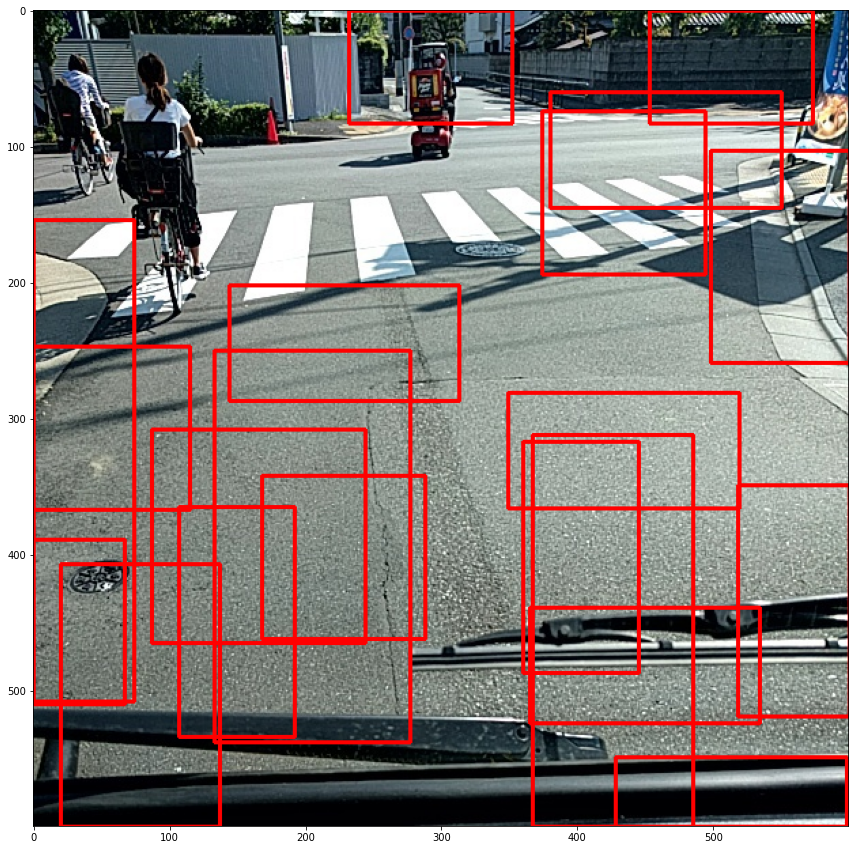

In [23]:
img = cv2.imread("/content/RoadDamageDataset/Adachi/JPEGImages/Adachi_20170908142224.jpg")  # [高さ][幅][色BGR]
W, H, _ = img.shape

for dbox in sample_dbox.values:
    cx = dbox[0] * W
    cy = dbox[1] * H
    w = dbox[2] * W
    h = dbox[3] * H

    xmin = int(np.clip(cx - w / 2, 0, W))
    xmax = int(np.clip(cx + w / 2, 0, W))
    ymin = int(np.clip(cy - h / 2, 0, H))
    ymax = int(np.clip(cy + h / 2, 0, H))

    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 0, 255), 2)

plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

連続するデフォルトボックスを描画

In [0]:
# DBox作成
dbox = DBox(ssd_cfg)
dbox_list = dbox.make_dbox_list()

dbox_list[:, :2] -= dbox_list[:, 2:] / 2  # 座標(xmin, ymin)へ変換 (cx, xyからwidth/2, height/2を引いている)
dbox_list[:, 2:] += dbox_list[:, :2]  # 座標(xmax, ymax)へ変換 (上で求めたxmin,xmaxにweight,heightを足している)

tensor([0.2980, 0.0875, 0.7020, 0.4915])
tensor([0.3300, 0.1195, 0.6700, 0.4595])
tensor([0.2596, 0.1693, 0.7404, 0.4097])
tensor([0.3798, 0.0491, 0.6202, 0.5299])
tensor([0.2056, 0.1913, 0.7944, 0.3876])
tensor([ 0.4019, -0.0050,  0.5981,  0.5839])


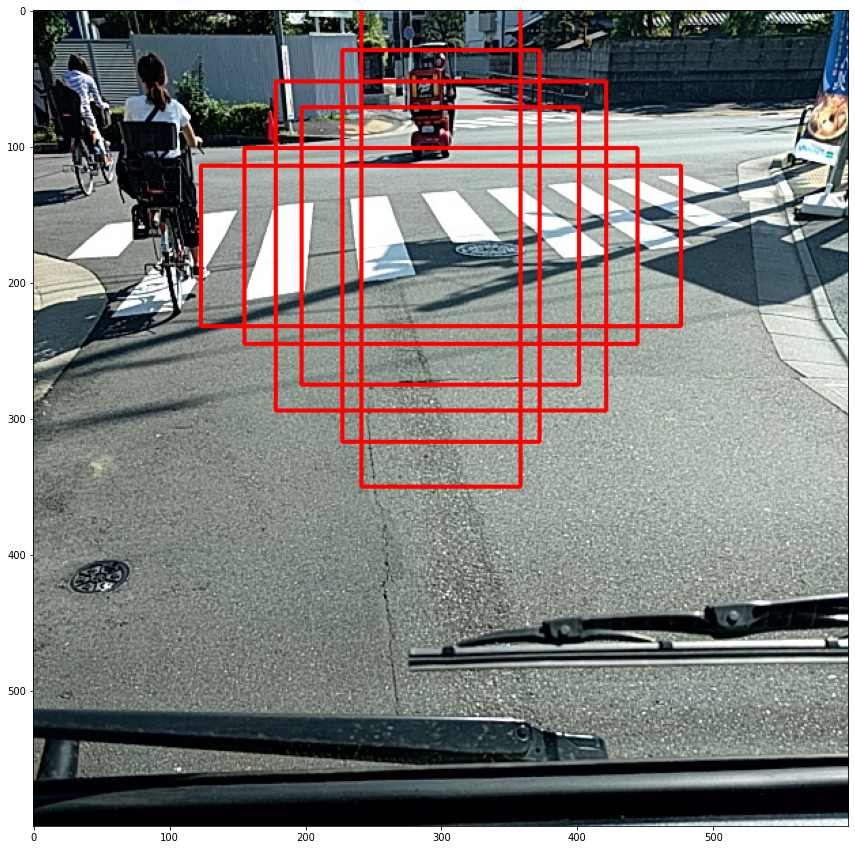

In [72]:
img = cv2.imread("/content/RoadDamageDataset/Adachi/JPEGImages/Adachi_20170908142224.jpg")  # [高さ][幅][色BGR]
W, H, _ = img.shape

for dbox in dbox_list[6400:6406]:
    print(dbox)
    xmin = int(dbox[0] * W)
    ymin = int(dbox[1] * H)
    xmax = int(dbox[2] * W)
    ymax = int(dbox[3] * H)

    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 0, 255), 2)

plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 順伝播

## decode

デフォルトボックスをオフセットにより変形させるクラスの実装

In [0]:
# オフセット情報を使い、DBoxをBBoxに変換する関数

def decode(loc, dbox_list, variances=[0.1, 0.2]):
    """
    オフセット情報を使い、DBoxをBBoxに変換する。

    Parameters
    ----------
    loc:  [8732,4]
        SSDモデルで推論するオフセット情報。
    dbox_list: [8732,4]
        DBoxの情報
     variances: BBoxの許容範囲

    Returns
    -------
    boxes : [xmin, ymin, xmax, ymax]
        BBoxの情報
    """

    # DBoxは[cx, cy, width, height]で格納されている
    # locも[Δcx, Δcy, Δwidth, Δheight]で格納されている

    # オフセット情報からBBoxを求める
    boxes = torch.cat((
        dbox_list[:, :2] + loc[:, :2] * variances[0] * dbox_list[:, 2:],
        dbox_list[:, 2:] * torch.exp(loc[:, 2:] * variances[1])), dim=1)
    # boxesのサイズはtorch.Size([8732, 4])となります

    # BBoxの座標情報を[cx, cy, width, height]から[xmin, ymin, xmax, ymax] に
    boxes[:, :2] -= boxes[:, 2:] / 2  # 座標(xmin, ymin)へ変換 (cx, xyからwidth/2, height/2を引いている)
    boxes[:, 2:] += boxes[:, :2]  # 座標(xmax, ymax)へ変換 (上で求めたxmin,xmaxにweight,heightを足している)

    return boxes

補正情報を0にして、バウンディングボックスを描画する

In [0]:
# DBox作成
dbox = DBox(ssd_cfg)
dbox_list = dbox.make_dbox_list()

In [0]:
loc = torch.tensor([[0., 0., 0., 0.] for i in range(8732)])

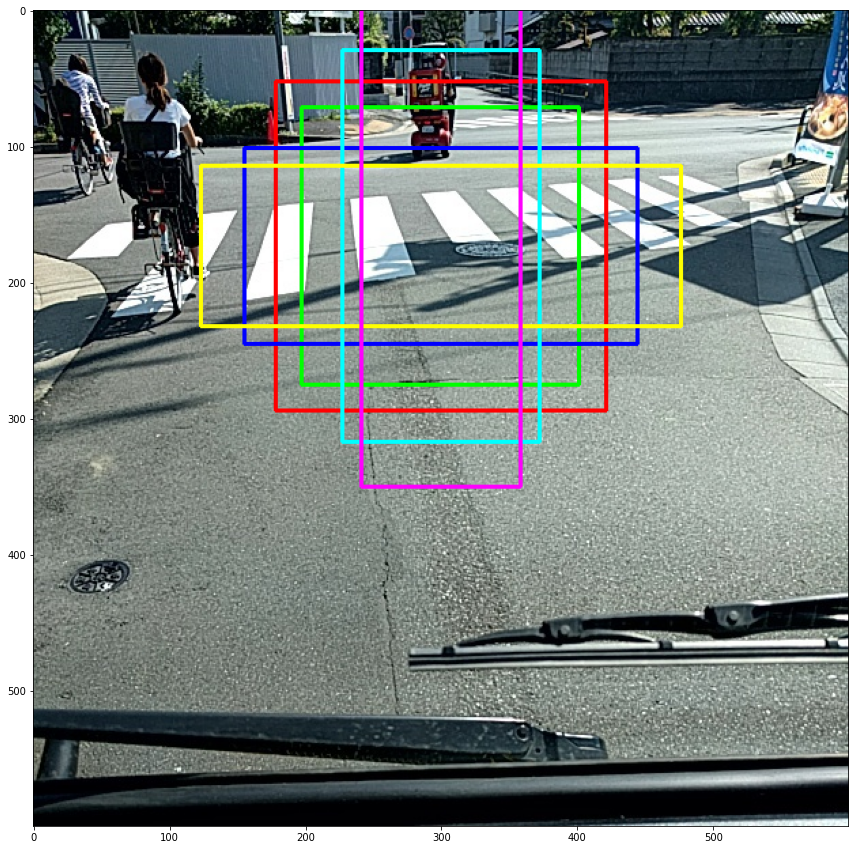

In [83]:
img = cv2.imread("/content/RoadDamageDataset/Adachi/JPEGImages/Adachi_20170908142224.jpg")  # [高さ][幅][色BGR]
W, H, _ = img.shape

colors = [(0, 0, 255), (0, 255, 0), (255, 0, 0), (255, 255, 0), (0, 255, 255), (255, 0, 255)]
for i, dbox in enumerate(decode(loc, dbox_list)[6400:6406]):
    xmin = int(dbox[0] * W)
    ymin = int(dbox[1] * H)
    xmax = int(dbox[2] * W)
    ymax = int(dbox[3] * H)

    
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), colors[i], 2)

plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

補正情報をランダムに初期化して、バウンディングボックスを描画する

In [0]:
# DBox作成
dbox = DBox(ssd_cfg)
dbox_list = dbox.make_dbox_list()

In [0]:
# 適当に設定
loc = torch.randn(8732, 4)

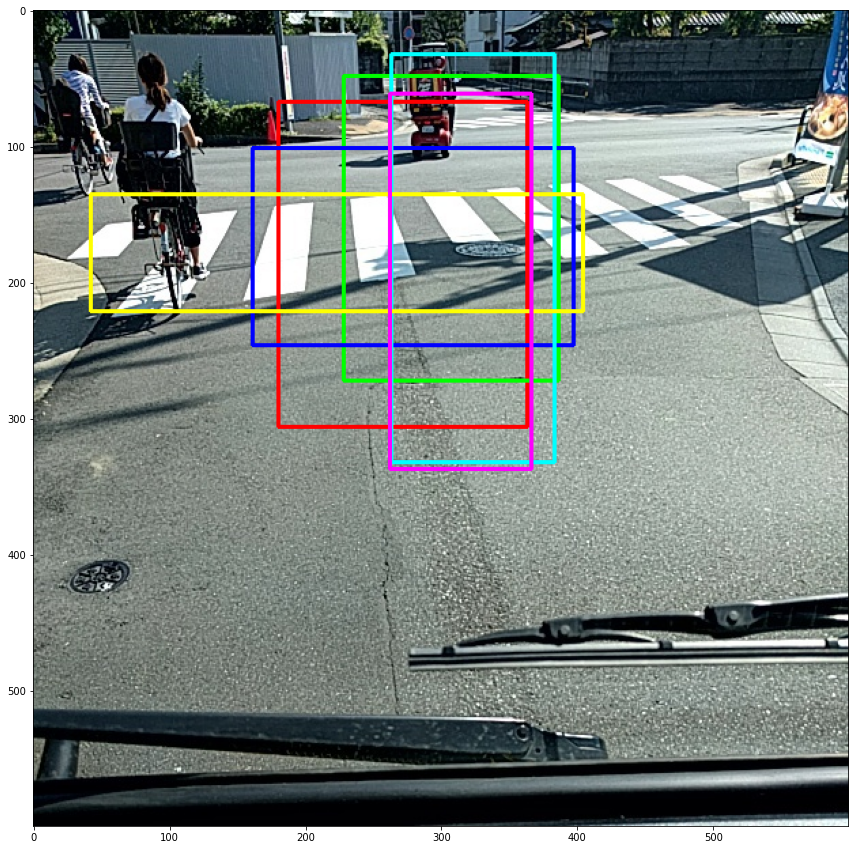

In [100]:
img = cv2.imread("/content/RoadDamageDataset/Adachi/JPEGImages/Adachi_20170908142224.jpg")  # [高さ][幅][色BGR]
W, H, _ = img.shape

colors = [(0, 0, 255), (0, 255, 0), (255, 0, 0), (255, 255, 0), (0, 255, 255), (255, 0, 255)]
for i, dbox in enumerate(decode(loc, dbox_list)[6400:6406]):
    xmin = int(dbox[0] * W)
    ymin = int(dbox[1] * H)
    xmax = int(dbox[2] * W)
    ymax = int(dbox[3] * H)

    
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), colors[i], 2)

plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

多少、バウンディングボックスが変形している(同じ色が対応している)

## Non-Maximum Suppression

8732個もデフォルトボックスを用意するため、一つの物体に似たような複数のバウンディングボックスが当てはめられてしまうのを防ぐ

In [176]:
scores = torch.tensor([0.2, 0.1, 0.5, 0.4])
scores.new_zeros(scores.size(0), dtype=torch.long)

tensor([0, 0, 0, 0])

In [177]:
scores.new()

tensor([])

In [178]:
v, idx = scores.sort(0)
v, idx

(tensor([0.1000, 0.2000, 0.4000, 0.5000]), tensor([1, 0, 3, 2]))

In [179]:
i = idx[-1]  # 現在のconf最大のindexをiに
print("before", idx)
idx = idx[:-1]
print("after", idx)

before tensor([1, 0, 3, 2])
after tensor([1, 0, 3])


In [190]:
boxes = torch.tensor([[0.1, 0.2, 0.3, 0.4], [0.6, 0.2, 0.4, 0.5], [0.2, 0.2, 0.3, 0.4], [0.3, 0.2, 0.3, 0.4]])
x1 = boxes[:, 0]   # 各要素の0番目をとっている
print("x1", x1)
tmp_x1 = boxes.new()
print("before", tmp_x1)
torch.index_select(x1, 0, idx, out=tmp_x1)  # idx(=[1, 0, 3])の順番にx1の0次元を対象に並び替えて、tmp_x1に代入
print("after", tmp_x1)

x1 tensor([0.1000, 0.6000, 0.2000, 0.3000])
before tensor([])
after tensor([0.6000, 0.1000, 0.3000])


In [183]:
print(i)
print("確信度が現在最も高いindexのx1の値", x1[i])

# clampしているのは、重なっている部分を算出するため
# 以下では、x1(左上の位置)が0.1と0.2(確信度が最大のDboxのx1の値)で、0.1は確信度が最大のDboxのx1の値の左にいるため、重なっていないことになるから、0.2でclampする必要がある
tmp_x1 = torch.clamp(tmp_x1, min=x1[i])
tmp_x1

tensor(2)
確信度が現在最も高いindexのx1の値 tensor(0.2000)


tensor([0.6000, 0.2000, 0.3000])

In [188]:
tmp_w = boxes.new()
x2 = boxes[:, 1]   # 各要素の0番目をとっている
tmp_x2 = boxes.new()
torch.index_select(x2, 0, idx, out=tmp_x2)
tmp_x2 = torch.clamp(tmp_x2, max=x2[i])
tmp_w.resize_as_(tmp_x2)

tensor([6.2125e-36, 0.0000e+00, 4.4842e-44])

In [0]:
# clampしているのは、重なっている部分を算出するため

In [0]:
# Non-Maximum Suppressionを行う関数

def nm_suppression(boxes, scores, overlap=0.45, top_k=200):
    """
    Non-Maximum Suppressionを行う関数。
    boxesのうち被り過ぎ（overlap以上）のBBoxを削除する。

    Parameters
    ----------
    boxes : [確信度閾値（0.01）を超えたBBox数,4]
        BBox情報。
    scores :[確信度閾値（0.01）を超えたBBox数]
        confの情報

    Returns
    -------
    keep : リスト
        confの降順にnmsを通過したindexが格納
    count：int
        nmsを通過したBBoxの数
    """

    # returnのひな形を作成
    count = 0
    keep = scores.new_zeros(scores.size(0), dtype=torch.long)
    # keep：torch.Size([確信度閾値を超えたBBox数])、要素は全部0

    # 各BBoxの面積areaを計算
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)

    # boxesをコピーする。後で、BBoxの被り度合いIOUの計算に使用する際のひな形として用意
    tmp_x1 = boxes.new()
    tmp_y1 = boxes.new()
    tmp_x2 = boxes.new()
    tmp_y2 = boxes.new()
    tmp_w = boxes.new()
    tmp_h = boxes.new()

    # socreを昇順に並び変える
    v, idx = scores.sort(0)

    # 上位top_k個（200個）のBBoxのindexを取り出す（200個存在しない場合もある）
    idx = idx[-top_k:]

    # idxの要素数が0でない限りループする
    while idx.numel() > 0:
        i = idx[-1]  # 現在のconf最大のindexをiに

        # keepの現在の最後にconf最大のindexを格納する
        # このindexのBBoxと被りが大きいBBoxをこれから消去する
        keep[count] = i
        count += 1

        # 最後のBBoxになった場合は、ループを抜ける
        if idx.size(0) == 1:
            break

        # 現在のconf最大のindexをkeepに格納したので、idxをひとつ減らす
        idx = idx[:-1]

        # -------------------
        # これからkeepに格納したBBoxと被りの大きいBBoxを抽出して除去する
        # -------------------
        # ひとつ減らしたidxまでのBBoxを、outに指定した変数として作成する
        torch.index_select(x1, 0, idx, out=tmp_x1)
        torch.index_select(y1, 0, idx, out=tmp_y1)
        torch.index_select(x2, 0, idx, out=tmp_x2)
        torch.index_select(y2, 0, idx, out=tmp_y2)

        # すべてのBBoxに対して、現在のBBox=indexがiと被っている値までに設定(clamp)
        tmp_x1 = torch.clamp(tmp_x1, min=x1[i])
        tmp_y1 = torch.clamp(tmp_y1, min=y1[i])
        tmp_x2 = torch.clamp(tmp_x2, max=x2[i])
        tmp_y2 = torch.clamp(tmp_y2, max=y2[i])

        # wとhのテンソルサイズをtmp_x2,tmp_y2と同じものにする
        tmp_w.resize_as_(tmp_x2)
        tmp_h.resize_as_(tmp_y2)

        # clampした状態でのBBoxの幅と高さを求める
        tmp_w = tmp_x2 - tmp_x1
        tmp_h = tmp_y2 - tmp_y1

        # 幅や高さが負になっているものは0にする
        tmp_w = torch.clamp(tmp_w, min=0.0)
        tmp_h = torch.clamp(tmp_h, min=0.0)

        # clampされた状態での面積を求める
        inter = tmp_w*tmp_h

        # IoU = intersect部分 / (area(a) + area(b) - intersect部分)の計算
        rem_areas = torch.index_select(area, 0, idx)  # 各BBoxの元の面積
        union = (rem_areas - inter) + area[i]  # 2つのエリアの和（OR）の面積
        IoU = inter/union

        # IoUがoverlapより小さいidxのみを残す
        idx = idx[IoU.le(overlap)]  # leはLess than or Equal toの処理をする演算です
        # IoUがoverlapより大きいidxは、最初に選んでkeepに格納したidxと同じ物体に対してBBoxを囲んでいるため消去

    # whileのループが抜けたら終了

    return keep, count

In [197]:
# 動作確認

# DBox作成
dbox = DBox(ssd_cfg)
dbox_list = dbox.make_dbox_list()

# オフセット情報を適当に設定
loc = torch.randn(8732, 4)
# バウンディングボックスごとの確信度も適当に設定
scores = torch.randn(8732)

# オフセット情報からバウンディングボックスを作成
decoded_dboxes = decode(loc, dbox_list)

# Non-Maximum Suppressionを実行
ids, count = nm_suppression(decoded_dboxes, scores, overlap=0.45, top_k=200)
print(ids)  # idsには後半には不要な値が入っている
print(count)  # 必要なdboxの数
print(ids[:count])  # 必要な部分のみ切り出し

using_dboxes = dbox_list[ids[:count]]
print(using_dboxes.shape)

tensor([3906, 6018, 8133,  ...,    0,    0,    0])
132
tensor([3906, 6018, 8133, 7129, 2847, 7453, 4023, 5832, 3166, 2721, 1809, 8436,
        6846, 2472, 8396, 5385, 1796, 3800, 3777, 4939, 1215, 5734, 1594, 5708,
        3237, 1591, 5906, 8249, 4868,  465, 4861, 5704, 7699, 1563, 1119, 1296,
        5584, 4026, 1505, 2957, 7377, 3506, 8315, 4656, 6260, 4476, 3881,  455,
        4428, 4603, 5494, 3984, 5394, 6778, 6308,  695, 4856,  486, 4082, 1370,
        8121,  780, 4259, 8244, 4159,  889, 5045,  706, 4547, 7993, 1786,  294,
        1336, 2737, 5331, 6816, 1612,  670, 2745, 1674, 2988, 3210, 2317,   27,
        8383, 7678, 5579, 5978, 1588, 5992, 4653,  863, 4339, 2639, 3635,  306,
        7207, 6917, 8481,  680,  732, 5611, 4331, 6668, 2177, 3819,  517, 2309,
        5205, 3072, 8334, 7978, 2919,  652, 2226, 2634, 3286, 7802, 5068, 4429,
         110, 2711, 4362,  963,  260, 7486,   53, 6558, 2509, 5019, 5470, 2784])
torch.Size([132, 4])


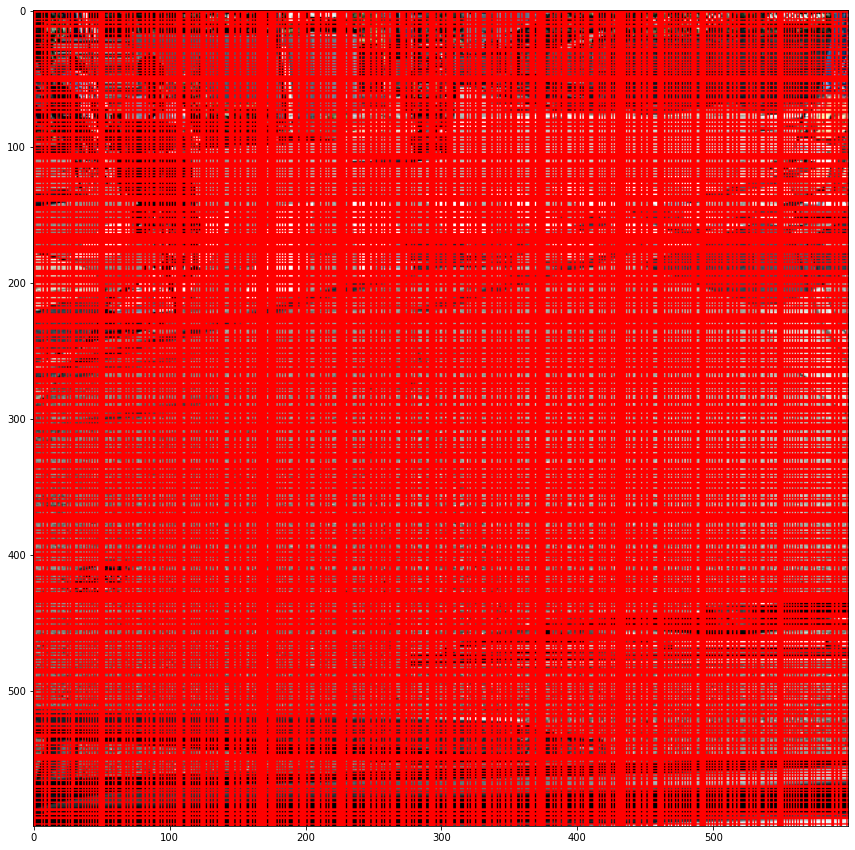

In [202]:
img = cv2.imread("/content/RoadDamageDataset/Adachi/JPEGImages/Adachi_20170908142224.jpg")  # [高さ][幅][色BGR]
W, H, _ = img.shape

# DBox作成
dbox = DBox(ssd_cfg)
dbox_list = dbox.make_dbox_list()
dbox_list[:, :2] -= dbox_list[:, 2:] / 2  # 座標(xmin, ymin)へ変換 (cx, xyからwidth/2, height/2を引いている)
dbox_list[:, 2:] += dbox_list[:, :2]  # 座標(xmax, ymax)へ変換 (上で求めたxmin,xmaxにweight,heightを足している)

for dbox in dbox_list:
    xmin = int(dbox[0] * W)
    ymin = int(dbox[1] * H)
    xmax = int(dbox[2] * W)
    ymax = int(dbox[3] * H)

    
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 0, 255), 1)

plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

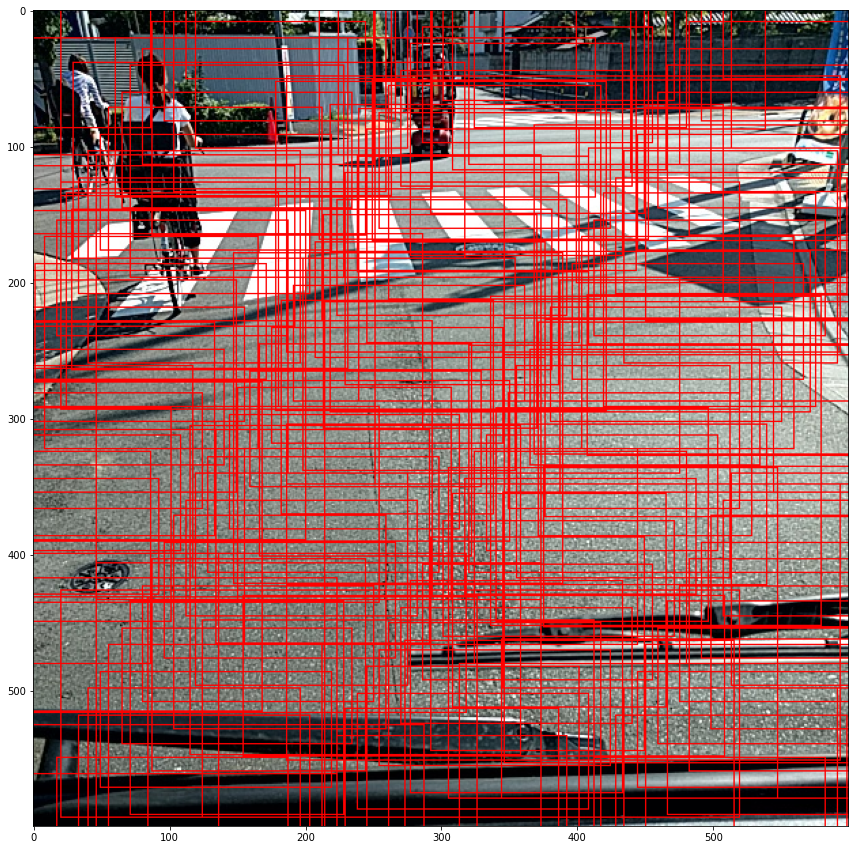

In [205]:
img = cv2.imread("/content/RoadDamageDataset/Adachi/JPEGImages/Adachi_20170908142224.jpg")  # [高さ][幅][色BGR]
W, H, _ = img.shape

# DBox作成
dbox = DBox(ssd_cfg)
dbox_list = dbox.make_dbox_list()
dbox_list[:, :2] -= dbox_list[:, 2:] / 2  # 座標(xmin, ymin)へ変換 (cx, xyからwidth/2, height/2を引いている)
dbox_list[:, 2:] += dbox_list[:, :2]  # 座標(xmax, ymax)へ変換 (上で求めたxmin,xmaxにweight,heightを足している)

for dbox in dbox_list[0:-1:50]:
    xmin = int(dbox[0] * W)
    ymin = int(dbox[1] * H)
    xmax = int(dbox[2] * W)
    ymax = int(dbox[3] * H)

    
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 0, 255), 1)

plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

バウンディングボックスを減らすことができる

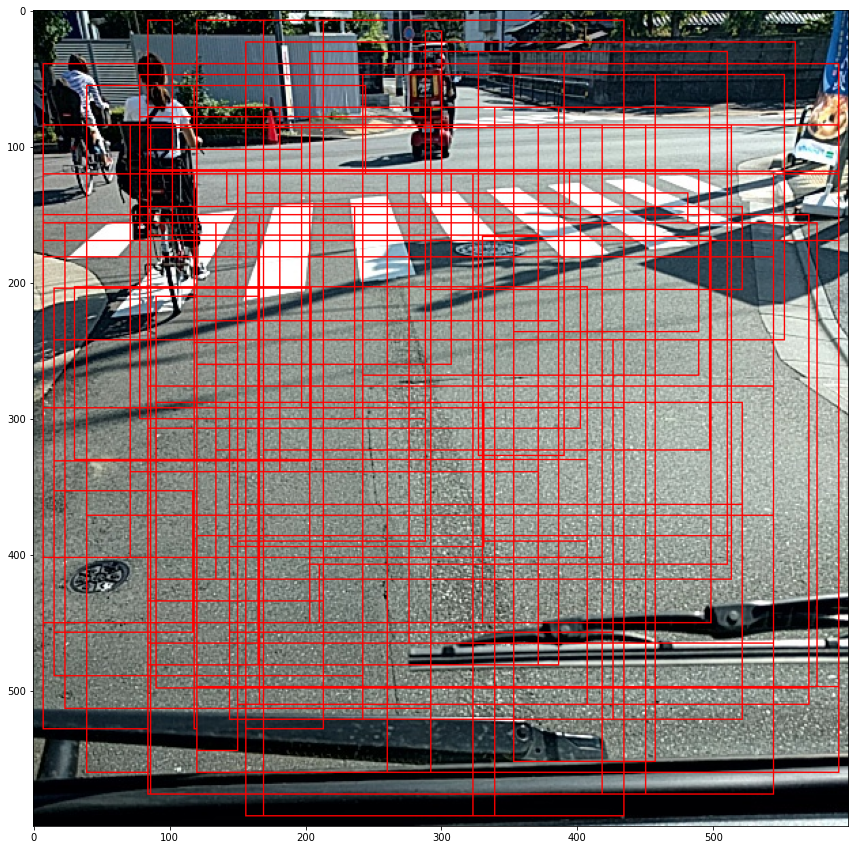

In [206]:
img = cv2.imread("/content/RoadDamageDataset/Adachi/JPEGImages/Adachi_20170908142224.jpg")  # [高さ][幅][色BGR]
W, H, _ = img.shape

for dbox in using_dboxes:
    xmin = int(dbox[0] * W)
    ymin = int(dbox[1] * H)
    xmax = int(dbox[2] * W)
    ymax = int(dbox[3] * H)

    
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 0, 255), 1)

plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

## Detect

In [0]:
# SSDの推論時にconfとlocの出力から、被りを除去したBBoxを出力する

class Detect(nn.Module):

    def __init__(self, conf_thresh=0.01, top_k=200, nms_thresh=0.45):
        super(Detect, self).__init__()
        self.softmax = nn.Softmax(dim=-1)  # confをソフトマックス関数で正規化するために用意
        self.conf_thresh = conf_thresh  # confがconf_thresh=0.01より高いDBoxのみを扱う
        self.top_k = top_k  # nm_supressionでconfの高いtop_k個を計算に使用する, top_k = 200
        self.nms_thresh = nms_thresh  # nm_supressionでIOUがnms_thresh=0.45より大きいと、同一物体へのBBoxとみなす

    def forward(self, loc_data, conf_data, dbox_list):
        """
        順伝搬の計算を実行する。

        Parameters
        ----------
        loc_data:  [batch_num,8732,4]
            オフセット情報。
        conf_data: [batch_num, 8732,num_classes]
            検出の確信度。
        dbox_list: [8732,4]
            DBoxの情報

        Returns
        -------
        output : torch.Size([batch_num, 21, 200, 5])
            （batch_num、クラス、confのtop200、BBoxの情報）
        """

        # 各サイズを取得
        num_batch = loc_data.size(0)  # ミニバッチのサイズ
        num_dbox = loc_data.size(1)  # DBoxの数 = 8732
        num_classes = conf_data.size(2)  # クラス数

        # confはソフトマックスを適用して正規化する
        conf_data = self.softmax(conf_data)


        # 出力の型を作成する。テンソルサイズは[minibatch数, 21, 200, 5]
        output = torch.zeros(num_batch, num_classes, self.top_k, 5)

        # cof_dataを[batch_num,8732,num_classes]から[batch_num, num_classes,8732]に順番変更
        conf_preds = conf_data.transpose(2, 1)

        # ミニバッチごとのループ
        for i in range(num_batch):

            # 1. locとDBoxから修正したBBox [xmin, ymin, xmax, ymax] を求める
            decoded_boxes = decode(loc_data[i], dbox_list)

            # confのコピーを作成
            conf_scores = conf_preds[i].clone()

            # 画像クラスごとのループ（背景クラスのindexである0は計算せず、index=1から）
            for cl in range(1, num_classes):

                # 2.confの閾値を超えたBBoxを取り出す
                # confの閾値を超えているかのマスクを作成し、
                # 閾値を超えたconfのインデックスをc_maskとして取得
                c_mask = conf_scores[cl].gt(self.conf_thresh)
                # gtはGreater thanのこと。gtにより閾値を超えたものが1に、以下が0になる
                # conf_scores:torch.Size([21, 8732])
                # c_mask:torch.Size([8732])

                # scoresはtorch.Size([閾値を超えたBBox数])
                scores = conf_scores[cl][c_mask]

                # 閾値を超えたconfがない場合、つまりscores=[]のときは、何もしない
                if scores.nelement() == 0:  # nelementで要素数の合計を求める
                    continue

                # c_maskを、decoded_boxesに適用できるようにサイズを変更します
                l_mask = c_mask.unsqueeze(1).expand_as(decoded_boxes)
                # l_mask:torch.Size([8732, 4])

                # l_maskをdecoded_boxesに適応します
                boxes = decoded_boxes[l_mask].view(-1, 4)
                # decoded_boxes[l_mask]で1次元になってしまうので、
                # viewで（閾値を超えたBBox数, 4）サイズに変形しなおす

                # 3. Non-Maximum Suppressionを実施し、被っているBBoxを取り除く
                ids, count = nm_suppression(boxes, scores, self.nms_thresh, self.top_k)
                # ids：confの降順にNon-Maximum Suppressionを通過したindexが格納
                # count：Non-Maximum Suppressionを通過したBBoxの数

                # outputにNon-Maximum Suppressionを抜けた結果を格納
                output[i, cl, :count] = torch.cat((scores[ids[:count]].unsqueeze(1), boxes[ids[:count]]), 1)

        return output  # torch.Size([1, 21, 200, 5])

# SSD

In [0]:
class SSD(nn.Module):
    def __init__(self, phase, cfg):
        super(SSD, self).__init__()

        self.phase = phase  # train or inferenceを指定
        self.num_classes = cfg["num_classes"]  # クラス数

        # SSDのネットワークを作る
        self.vgg = make_vgg()
        self.extras = make_extras()
        self.L2Norm = L2Norm()
        self.loc = make_loc(cfg["num_classes"], cfg["bbox_aspect_num"])
        self.conf = make_conf(cfg["num_classes"], cfg["bbox_aspect_num"])

        # DBox作成
        dbox = DBox(cfg)
        self.dbox_list = dbox.make_dbox_list()

        # 推論時はクラス「Detect」を用意します
        if phase == 'inference':
            self.detect = Detect()

    def forward(self, x):
        sources = list()  # locとconfへの入力source1～6を格納
        loc = list()  # locの出力を格納
        conf = list()  # confの出力を格納

        # vggのconv4_3まで計算する
        for k in range(23):
            x = self.vgg[k](x)

        # conv4_3の出力をL2Normに入力し、source1を作成、sourcesに追加
        source1 = self.L2Norm(x)
        sources.append(source1)

        # vggを最後まで計算し、source2を作成、sourcesに追加
        for k in range(23, len(self.vgg)):
            x = self.vgg[k](x)

        sources.append(x)

        # extrasのconvとReLUを計算
        # source3～6を、sourcesに追加
        for k, v in enumerate(self.extras):
            x = F.relu(v(x), inplace=True)
            if k % 2 == 1:  # conv→ReLU→cov→ReLUをしたらsourceに入れる
                sources.append(x)

        # source1～6に、それぞれ対応する畳み込みを1回ずつ適用する
        # zipでforループの複数のリストの要素を取得
        # source1～6まであるので、6回ループが回る
        for (x, l, c) in zip(sources, self.loc, self.conf):
            # Permuteは要素の順番を入れ替え
            loc.append(l(x).permute(0, 2, 3, 1).contiguous())
            conf.append(c(x).permute(0, 2, 3, 1).contiguous())
            # l(x)とc(x)で畳み込みを実行
            # l(x)とc(x)の出力サイズは[batch_num, 4*アスペクト比の種類数, featuremapの高さ, featuremap幅]
            # sourceによって、アスペクト比の種類数が異なり、面倒なので順番入れ替えて整える
            # permuteで要素の順番を入れ替え、
            # [minibatch数, featuremap数, featuremap数,4*アスペクト比の種類数]へ
            # （注釈）
            # torch.contiguous()はメモリ上で要素を連続的に配置し直す命令です。
            # あとでview関数を使用します。
            # このviewを行うためには、対象の変数がメモリ上で連続配置されている必要があります。

        # さらにlocとconfの形を変形
        # locのサイズは、torch.Size([batch_num, 34928(=8732*オフセット数(4))])
        # confのサイズはtorch.Size([batch_num, 8732*クラス数])になる
        loc = torch.cat([o.view(o.size(0), -1) for o in loc], 1)
        conf = torch.cat([o.view(o.size(0), -1) for o in conf], 1)

        # さらにlocとconfの形を整える
        # locのサイズは、torch.Size([batch_num, 8732, 4])
        # confのサイズは、torch.Size([batch_num, 8732, クラス数])
        loc = loc.view(loc.size(0), -1, 4)
        conf = conf.view(conf.size(0), -1, self.num_classes)

        # 最後に出力する
        output = (loc, conf, self.dbox_list)

        if self.phase == "inference":  # 推論時
            # クラス「Detect」のforwardを実行
            # 返り値のサイズは torch.Size([batch_num, クラス数, 200, 5])
            return self.detect(output[0], output[1], output[2])

        else:  # 学習時
            return output
            # 返り値は(loc, conf, dbox_list)のタプル

In [0]:
# 動作の確認

# SSD300の設定
ssd_cfg = {
    "num_classes": 8,
    "input_size": 300,  # 画像の入力サイズ
    "bbox_aspect_num": [4, 6, 6, 6, 4, 4],  # 出力するDboxのアスペクト比の種類
    "feature_maps": [38, 19, 10, 5, 3, 1], # 各sourceの画像サイズ
    "s_min": 0.2,
    "s_max":0.9,
    "aspect_ratios":[1, 2, 1/2, 3, 1/3]  # 順番重要(bbox_aspect_numが4種類の時に前から4つである1, 2, 1/2をして欲しいため)
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SSD("inference", ssd_cfg)

In [472]:
model

SSD(
  (vgg): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [0]:
# google colobでモジュール読み込みのために必要
import sys
sys.path.append("/content/drive/My Drive/study/CNN/Object_Detection/utils")

from path2dataloader import make_data_path_list
from path2dataloader import Anno_xml2list
from path2dataloader import DataTransform

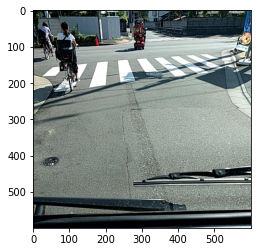

In [474]:
image_file_path = "/content/RoadDamageDataset/Adachi/JPEGImages/Adachi_20170908142224.jpg"
img = cv2.imread(image_file_path)
height, width, channels = img.shape

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [0]:
input_size = 300
transform = DataTransform(input_size)
phase = "val"
img_transformed, boxes, labels = transform(img, "", "")
img = torch.from_numpy(img_transformed[:, :, (2, 1, 0)]).permute(2, 0, 1)

In [476]:
img.shape

torch.Size([3, 300, 300])

In [477]:
model.eval()
x = img.unsqueeze(0)
detections = model(x)

print(detections.shape)  # torch.size([バッチサイズ, クラス数, 確信度のtop200, 規格化されたバウンディングボックスの情報(確信度, xmin, ymin, xmax, ymax)])
print(detections)

torch.Size([1, 8, 200, 5])
tensor([[[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

         [[ 0.3138,  0.8216,  0.2860,  1.1273,  0.5263],
          [ 0.3090,  0.8239,  0.0733,  1.1281,  0.3104],
          [ 0.3060,  0.8376,  0.8095,  1.1327,  1.0497],
          ...,
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

         [[ 0.1935, -0.0911,  0.2431,  0.1106,  0.4564],
          [ 0.1838,  0.7023,  0.8569,  0.9017,  1.0665],
          [ 0.1745, -0.0883,  0.0625,  0.1076,  0.2655],
          ...,
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 

In [0]:
# 可視化したい!